# FCA

Technical Challenge for Data Science Candidates

This workbook loads a pickle file from the prior notebook.

Naive Model

In [434]:
import numpy as np
import pandas as pd
import math
import json

from os import path

from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import tree
from sklearn import ensemble
from sklearn import metrics

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

import scipy.stats as st
import statsmodels as sm
import statsmodels.api as smi
from sklearn import svm

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

from cycler import cycler
import matplotlib.pyplot as plt
import seaborn as sns

pd.__version__

'0.24.2'

In [347]:
# If you turn this feature on, you can display each result as it happens.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [348]:
# this is the local Utility module and it reloaded each time.
from fca import Utility

In [349]:
%load_ext autoreload
%autoreload 1
%aimport fca

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [350]:
# My utility singleton.
i0 = Utility.instance()

## Modelling

There are some highly correlated features that might be confusing.
Build a naive model that uses all the features and refine it down.

Filter the dataset and then apply a selection of models.

In [389]:
# df2 = pd.read_pickle("coded.pickle")
df2 = pd.read_pickle("scaled.pickle")

In [390]:
# re-instate the boolean binary outcome
df2.y = df2.y > 0
df2.y;

In [391]:
## Low incidence rate may require some up-sampling.
np.sum(df2.y.values) / len(df2.y)

0.11265417111780131

### Reload the dataset for the model

You need to run this after you have chosen and evaluated to reset the dataset.
There is no scaling needed for the models chosen.
If you run all cells, the default is evaluate for the never-active with logistic regression.

### Splitting

I use sample0 for the different datasets. 
 1. use a train/test split
 2. use everything - let cross-validation make the splits

In [392]:
sample0=2

### Case 0: Prescient data

Null hypothesis.

I include the outcome variable - forcing over-fitting. All the models should converge to one. Or the data is structurally unsound (mis-scaled) or completely noise. I then remove each of the prescient variables.

In [369]:
y = df2.y
# X = df2.drop(columns=['y'])
X = df2

### Case 1: All features

Remove the outcome and get a baseline

In [395]:
y = df2.y
X = df2.drop(columns=['y'])
# X = df2
X.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'job0', 'marital0',
       'education0', 'default0', 'housing0', 'loan0', 'poutcome0', 'pdays0'],
      dtype='object')

### Case 2: case 1 and other refinements


In [321]:
# Remove highly-correlated features
# default is an historical - if loan given will they default
pcols = ['default', 'poutcome', 'pdays', 'previous' ]
pcols = pcols + ['euribor3m', 'emp.var.rate',  'cons.conf.idx']
pcols

['default',
 'poutcome',
 'pdays',
 'previous',
 'euribor3m',
 'emp.var.rate',
 'cons.conf.idx']

In [322]:
X = X.drop(columns=pcols)
X.columns

Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'duration', 'campaign', 'cons.price.idx',
       'nr.employed'],
      dtype='object')

### Split the Data

In [396]:
Xcols = list(X.columns)
if sample0 == 1:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
elif sample0 == 2:
    X_train, X_test, y_train, y_test = ( X, None, y, None )

In [397]:
X_train.shape
y_train.shape
Xcols

(41188, 28)

(41188,)

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'job0',
 'marital0',
 'education0',
 'default0',
 'housing0',
 'loan0',
 'poutcome0',
 'pdays0']

## Model cases

Again choose one to apply to the data you've chosen.

These are a number of models that can be applied. Some are 'patchy', results have high variance. Some are good for spotting mal-formed features.

    1. The first SVC is not practical for "big" data (width and count), but works well for smaller ones.

    2. The Multi-Layer Perceptron Classifier is a useful neural network and can get reasonable results quickly - it parallizes well. The hidden_layer_sizes need tuning to get a cross validation score over 0.5. Can be patchy. Spots prescients.

    3. The logistic regression is a very solid performer - not patchy. Usually spots prescients.

    4. Gradient-boosted is fast and spots prescients.

    5. Random-forest usually gets balanced results
    
When the MLPC is patchy, it usually means there is a useful split to be made. There is a Decision Tree Classifier below that can help find the split.

In [325]:
clf = svm.SVC(kernel='linear', C=1)

In [398]:
# Useful method. Reduce the size of the neural network to find a path with prescient features. log_2 should be minimal
x0 = math.floor(math.log(X.shape[1], 2))
clf =  MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(x0, x0, 2), 
                     random_state=1, warm_start=True)

In [381]:
original_params = {'n_estimators': 1000, 'max_leaf_nodes': 8, 'max_depth': None, 'random_state': 2,
                   'min_samples_split': 8}
params = original_params

clf = ensemble.GradientBoostingClassifier(**params)

In [383]:
clf = ensemble.RandomForestClassifier(max_depth=2, random_state=0)

In [428]:
clf = LogisticRegression(C=1e4, solver='lbfgs', multi_class='auto', max_iter=10000) # max_iter is 2 orders up!

In [ ]:
clf = DecisionTreeClassifier()

tree.plot_tree(clf.fit(X_train, y_train)) 

## From cross-validation results, choose the most accurate model

To evaluate the model under a cross-validation scheme, run this cell.

In [405]:
scores = cross_val_score(clf, X_train, y_train, cv=5, error_score=np.nan)
scores

array([0.8884438 , 0.36028162, 0.62078174, 0.18331917, 0.14228481])

## Feature selection

Try to determine best features

In [400]:
clf

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(4, 4, 2), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=True)

In [386]:
# create the RFE model and select 3 attributes
rfe = RFE(clf, 5)
rfe = rfe.fit(X_train, y_train)
# summarize the selection of the attributes
rfe.support_
rfe.ranking_

/misc/share/0/anaconda3/envs/gensim/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/misc/share/0/anaconda3/envs/gensim/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/misc/share/0/anaconda3/envs/gensim/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/misc/share/0/anaconda3/envs/gensim/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureW

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False])

array([25, 24, 23, 22, 19, 21, 20, 17, 18, 16,  9, 15,  1, 12, 11,  7, 13,
        1,  1,  1,  1, 10,  8,  6,  5,  4, 14,  3,  2])

In [387]:
x0 = np.array(Xcols)
list(x0[rfe.support_])

['pdays', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']

In [388]:
idxs = list(np.where(rfe.support_)[0])
idxs
Xcols

[12, 17, 18, 19, 20]

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y',
 'job0',
 'marital0',
 'education0',
 'default0',
 'housing0',
 'loan0',
 'poutcome0',
 'pdays0']

### Decision Tree Classifier

This is hard work for scikit-learn

In [435]:
## Look at a decision tree
# This can spot patches
clf = tree.DecisionTreeClassifier()

In [436]:
# Train Decision Tree Classifer

cols = X_train.columns
cols = set(cols).difference(set(filter(lambda x: x.endswith("0"), cols)))
cols = ['age', 'job', 'marital', 'education']
cols

clf = clf.fit(X_train[cols], y_train)
y_pred = clf.predict(X_train[cols])
metrics.accuracy_score(y_train, y_pred)

['age', 'job', 'marital', 'education']

0.8969117218607361

In [432]:
#Predict the response for test dataset
y_pred = clf.predict(X_test)

metrics.accuracy_score(y_test, y_pred)

ValueError: Expected 2D array, got scalar array instead:
array=nan.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

[Text(167.4, 199.32, 'nr.employed <= -1.099\nentropy = 0.2\nsamples = 41188\nvalue = [36548, 4640]\nclass = 0'),
 Text(83.7, 163.07999999999998, 'duration <= -0.331\nentropy = 0.494\nsamples = 4964\nvalue = [2755, 2209]\nclass = 0'),
 Text(41.85, 126.83999999999999, 'poutcome <= 2.918\nentropy = 0.287\nsamples = 1891\nvalue = [1563, 328]\nclass = 0'),
 Text(20.925, 90.6, 'duration <= -0.52\nentropy = 0.228\nsamples = 1605\nvalue = [1394, 211]\nclass = 0'),
 Text(10.4625, 54.359999999999985, 'duration <= -0.697\nentropy = 0.126\nsamples = 991\nvalue = [924, 67]\nclass = 0'),
 Text(5.23125, 18.119999999999976, '\n  (...)  \n'),
 Text(15.693750000000001, 18.119999999999976, '\n  (...)  \n'),
 Text(31.387500000000003, 54.359999999999985, 'emp.var.rate <= -1.166\nentropy = 0.359\nsamples = 614\nvalue = [470, 144]\nclass = 0'),
 Text(26.15625, 18.119999999999976, '\n  (...)  \n'),
 Text(36.61875, 18.119999999999976, '\n  (...)  \n'),
 Text(62.775000000000006, 90.6, 'duration <= -0.427\nentro

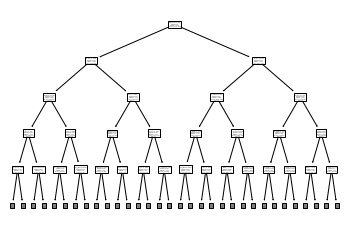

In [440]:
tree.plot_tree(clf.fit(X_train, y_train), max_depth=4, feature_names = list(X_train.columns), class_names=['0','1'])

In [442]:
dot_data = 'tree.dot'
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, max_depth=4, feature_names = X_train.columns, class_names=['0','1'])

# Summary

Case 1. Never active. The models all fit quickly and over cross-validation manage to get to over 90% accuracy.
Only MLPC struggles.

Case 2. Inactive for over a year. SVM really struggles to converge. Logistic regression needs 10000 iterations but gets to over 90%. MLPC gets there but is probably over-fitting.

Case 3. Inactive for over a month. MLCP gets 30% with full layers. Logistic regression can get to over 75%.

Running through the models, and looking at the feature selection, it seems that, for all cases, if a user has had transaction declined, or has had one reverted or declared as pending, then they prove to be inactive. For some reason a notification of ONBOARDING_TIPS_ACTIVATED_USERS seems to be a good indicator. This might be that account-holders who are having trouble ask for help in the form of onboarding tips.